In [60]:
from PIL import Image
import os
import skimage as sk
import napari
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from napari_animation import Animation
import imagecodecs
from tifffile import imread

os.chdir('C:\\Users\\oadeji01\\OneDrive - Tufts\\Bunmi\\SHG\\SHG_20250207')
sns.set_theme(font_scale=2, style = 'whitegrid', context= 'notebook')


#img = Image.open('SHG_20241022\\UCT0.5_pre\\UCT0.5_pre.tif')

In [2]:
os.listdir()[1].split('_ch')#[1].split('.t')#[0]

['20250116_SHG.lif']

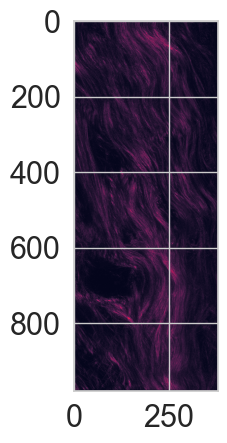

In [31]:
plt.imshow(imread("20250128_SHG_0.5RF_Control_Merging_001_ch00.tif")[0, :, 200:580, 1])#160:350

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(binary_image, cmap="gray")  # Show original binary fibers image

for region in regionprops(label_image):
    y0, x0 = region.centroid
    orientation = region.orientation
    length = region.major_axis_length / 2
    
    x1 = x0 + length * np.cos(orientation)
    y1 = y0 - length * np.sin(orientation)  # Adjust for image coordinate system
    x2 = x0 - length * np.cos(orientation)
    y2 = y0 + length * np.sin(orientation)
    
    ax.plot((x1, x2), (y1, y2), '-r', linewidth=2)

plt.show()

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import filters, measure
from scipy.ndimage import gaussian_filter
import napari


# Load the grayscale image
for file in os.listdir():#SHG_20241212\\img_stacks
    f = os.path.join(file)
    #print(f)
    #print(f.split('\\')[2].split('.t')[0])
    if f.endswith('.tif'):
        # Load the 4D Z-stack image (adjust for the actual image dimensions)
        image = imread(f)[:, :, 160:350, 1]

        # Apply a Gaussian filter to smooth the image
        smoothed_image = [gaussian_filter(x, sigma=1) for x in image]

        # Apply a threshold to binarize the image
        threshold_value = [filters.threshold_otsu(x) for x in smoothed_image]
        binary_image = np.array([x > y for x, y in zip(smoothed_image, threshold_value)])

        # Create lists to store the colored images for all slices
        colored_images = []

        # Loop over the binary image slices
        for id, x in enumerate(binary_image):

            #print(f"Processing slice {id}...")

            # Label the objects in the image
            labeled_slice, num_labels = measure.label(x, return_num=True)

            # Compute region properties
            props = measure.regionprops(labeled_slice)

            # Calculate density for each object
            densities = []
            for prop in props:
                area = prop.area  # Area of the object
                density = area / prop.convex_area if prop.convex_area > 0 else 0
                densities.append(density)

            # Normalize densities for coloring
            max_density = max(densities) if densities else 1
            normalized_densities = [d / max_density for d in densities]

            # Create a color map for the labels based on density
            colored_image = np.zeros((*labeled_slice.shape, 3))  # RGB image
            for prop, density in zip(props, normalized_densities):
                color_value = plt.cm.viridis(density)  # Viridis colormap
                for coord in prop.coords:  # Apply color to each pixel of the object
                    colored_image[coord[0], coord[1]] = color_value[:3]  # RGB values

            # Append the colored image for this slice
            colored_images.append(colored_image)

        # Stack the colored images together (if you want to visualize them in a single stack)
        colored_images_stack = np.array(colored_images)

        # Now you can visualize using Napari
        viewer = napari.Viewer(title=f)
        viewer.add_image(image, name="Original Image")
        viewer.add_image(binary_image, name="Binary Image")
        viewer.add_image(colored_images_stack, name="Colored by Density")

        # Start the Napari GUI
        napari.run()


In [61]:
from tifffile import imread


stack_properties = []
for file in os.listdir():#SHG_20241212\\img_stacks
    f = os.path.join(file)
    #print(f)
    #print(f.split('\\')[2].split('.t')[0])
    if f.endswith('.tif')  and 'ch' in f:
        img_st = imread(f)[:, :, 200:580, 1]
        #print(img_st.shape)
       
        st_gauss = np.array([sk.filters.gaussian(im) for im in img_st])
        img_equal = np.array([sk.filters.sobel(im) for im in st_gauss])
        #print(img_st.shape)
        #print(st_gauss.shape)
        st_canny = np.array([sk.feature.canny(im, sigma = 0) for im in img_equal])
        st_skeleton = np.array([sk.morphology.skeletonize(im) for im in st_canny])

        '''view = napari.Viewer(title=f)
        view.add_image(img_st)
        view.add_image(st_gauss)
        view.add_image(im_equal)
        view.add_image(st_canny)
        view.add_image(st_skeleton)
        napari.run()'''
#Save 3d rendering
        '''animation = Animation(view)
        animation.capture_keyframe()
        view.camera.zoom *= 1.5
        animation.capture_keyframe()

        animation.animate(f'{f}_3d_img.mp4', fps=30)'''


        properties = []
        for id, slice in enumerate(st_skeleton):
            #plt.imshow(slice, cmap = 'gray')
            labeled_slice, num_labels = sk.measure.label(slice, return_num=True)
            #print(num_labels)
            props = sk.measure.regionprops(labeled_slice, intensity_image=labeled_slice)
            num_fibers = labeled_slice.mean()
            slice_props = [{
                            'image_name': f.split('_ch')[0], 
                            'fiber_count': num_fibers,
                            'intensity': prop.mean_intensity,
                            'slice':id, 
                            'label': prop.label, 
                            'area': prop.area, 
                            'centroid': prop.centroid, 
                            'orientation': prop.orientation, 
                            'length': prop.perimeter,
                            'density': prop.area/prop.convex_area if prop.convex_area > 0 else 0
                            } 
                            for prop in props]
            properties.extend(slice_props)

        stack_properties.append(properties)


In [62]:
df = pd.concat([pd.DataFrame(x) for x in stack_properties])
centroid = pd.DataFrame(df['centroid'].to_list(), columns= ['centroid_x', 'centroid_y'])

In [63]:
df.head()

,image_name,fiber_count,intensity,slice,label,area,centroid,orientation,length,density
0,0.5RF_Control_12mins_Merging_001,7.759193,1.0,0,1,17.0,"(12.176470588235293, 233.0)",1.409743,15.828427,0.586207
1,0.5RF_Control_12mins_Merging_001,7.759193,2.0,0,2,14.0,"(16.857142857142858, 237.64285714285714)",1.039313,11.242641,0.538462
2,0.5RF_Control_12mins_Merging_001,7.759193,3.0,0,3,16.0,"(20.3125, 234.5)",1.477733,14.621320,0.571429
3,0.5RF_Control_12mins_Merging_001,7.759193,4.0,0,4,32.0,"(27.53125, 282.1875)",1.282186,31.142136,0.347826
4,0.5RF_Control_12mins_Merging_001,7.759193,5.0,0,5,11.0,"(48.0, 277.54545454545456)",-0.400221,10.449747,0.550000


In [64]:
deets = df.image_name.str.split('_', expand=True).drop(0, axis=1)
deets = deets.rename({1: 'sample', 2: 'trt_level', 3: 'treated', 4: 'wv'}, axis=1)
df = pd.concat([deets, df.iloc[:, 1:]], axis = 1)
df.insert(13, 'norm_density', [d / df['density'].sum() for d in df['density']])
df.insert(3, 'trt', np.where(df['treated'].str.contains('Control'), 'Control', '0.5RF'))
df

,sample,trt_level,treated,trt,wv,fiber_count,intensity,slice,label,area,centroid,orientation,length,density,norm_density
0,Control,12mins,Merging,0.5RF,001,7.759193,1.0,0,1,17.0,"(12.176470588235293, 233.0)",1.409743,15.828427,0.586207,0.000021
1,Control,12mins,Merging,0.5RF,001,7.759193,2.0,0,2,14.0,"(16.857142857142858, 237.64285714285714)",1.039313,11.242641,0.538462,0.000019
2,Control,12mins,Merging,0.5RF,001,7.759193,3.0,0,3,16.0,"(20.3125, 234.5)",1.477733,14.621320,0.571429,0.000020
3,Control,12mins,Merging,0.5RF,001,7.759193,4.0,0,4,32.0,"(27.53125, 282.1875)",1.282186,31.142136,0.347826,0.000012
4,Control,12mins,Merging,0.5RF,001,7.759193,5.0,0,5,11.0,"(48.0, 277.54545454545456)",-0.400221,10.449747,0.550000,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,Treated,7mins,Merging,0.5RF,001,0.006460,4.0,11,4,40.0,"(840.05, 55.8)",-1.012987,40.213203,0.360360,0.000013
1601,Treated,7mins,Merging,0.5RF,001,0.006460,5.0,11,5,2.0,"(842.5, 67.5)",-0.785398,0.000000,1.000000,0.000035
1602,Treated,7mins,Merging,0.5RF,001,0.006460,6.0,11,6,136.0,"(865.6323529411765, 20.125)",-1.049685,145.888348,0.253731,0.000009
1603,Treated,7mins,Merging,0.5RF,001,0.006460,7.0,11,7,107.0,"(878.1308411214953, 18.214953271028037)",-1.024141,112.947222,0.218814,0.000008


In [19]:
df['mag'] = df.mag.replace('961.6nm','962nm')

In [65]:
df.groupby(['wv', 'trt_level', 'treated']).median(numeric_only=True).reset_index()

,wv,trt_level,treated,fiber_count,intensity,slice,label,area,orientation,length,density,norm_density
0,001,12mins,Merging,57.797501,414.0,4.0,414.0,12.0,-0.026910,10.485281,0.520000,0.000018
1,001,17mins,Merging,15.738474,244.0,6.0,244.0,12.0,0.000000,11.656854,0.500000,0.000018
2,001,22mins,Merging,4.552459,113.0,6.0,113.0,17.0,-0.340937,16.449747,0.452381,0.000016
3,001,2mins,Merging,19.463737,274.0,3.0,274.0,15.0,0.000000,14.278175,0.473684,0.000017
4,001,7mins,Merging,8.164490,176.0,6.0,176.0,11.0,-0.565657,9.828427,0.552178,0.000020


In [39]:
df.groupby(['wv', 'trt_level', 'treated']).std(numeric_only=True).reset_index()

,wv,trt_level,treated,fiber_count,intensity,slice,label,area,orientation,length,norm_density,density
0,Merging,0.5RF,Control,1.918343,93.981386,5.608072,93.981386,45.475193,0.506528,49.182440,0.000004,0.186147
1,Merging,0.5RF,Control2,20.183758,362.975523,6.695755,362.975523,316.032564,0.456512,333.236484,0.000005,0.265220
2,Merging,0.5RF,Treated,6.082117,236.823697,6.784717,236.823697,47.065755,0.342220,48.292011,0.000005,0.239432
3,Merging,0.5RF,Treated2,6.812357,313.827825,7.071907,313.827825,56.741600,0.317252,58.018568,0.000005,0.248262


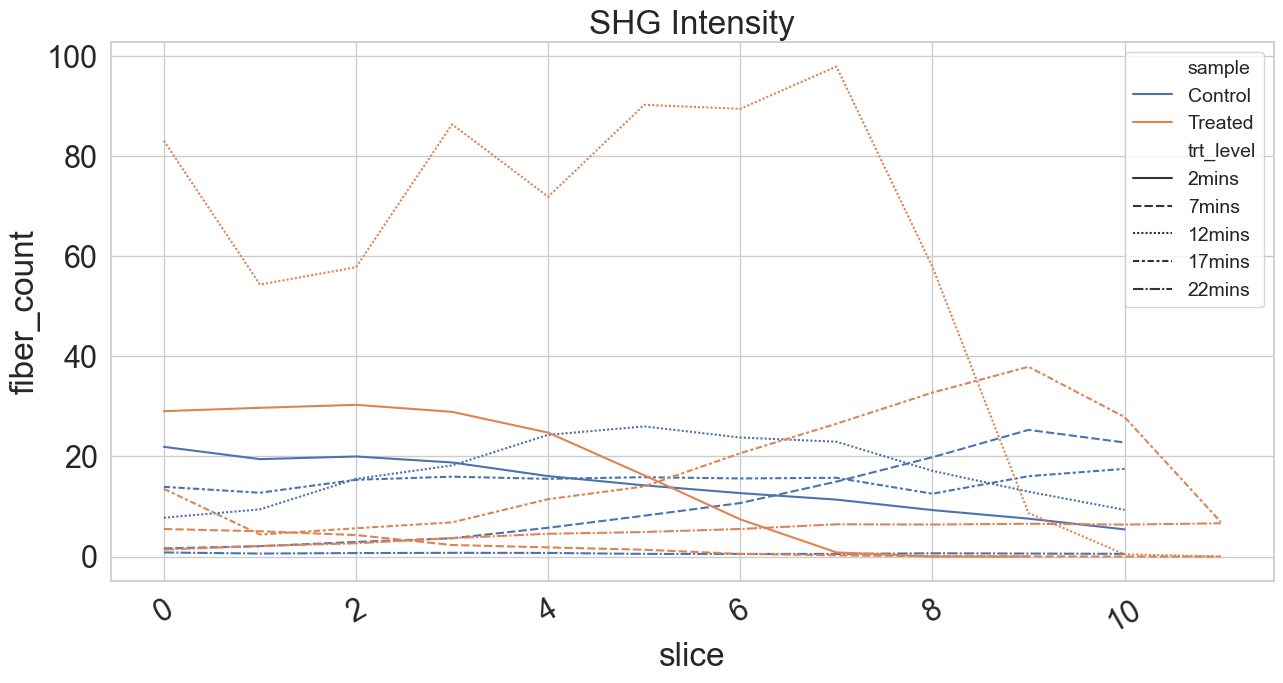

In [71]:
plt.figure(figsize = (15, 7))
sns.lineplot(
            data = df[df['treated'].isin(['Control2']) == False], #[(df.slice <=20)],#(df.trt_level <= '0.5RF') & [(df['slice'] == 0)]
            x = 'slice',
            y = 'fiber_count',
            hue = 'sample',
            #estimator='median',
            errorbar='se',
            #log_scale = True,
            #width=.25,
            #gap = .3,
            #hue_order = ['0.1RF', '0.5RF'],
            style = 'trt_level',
            style_order = ['2mins', '7mins', '12mins', '17mins', '22mins'],
            err_style='bars'
            )
plt.xticks(rotation = 30);
plt.title('SHG Intensity')
plt.legend(fontsize = 14)

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_26984\2195029287.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor = (1,1));


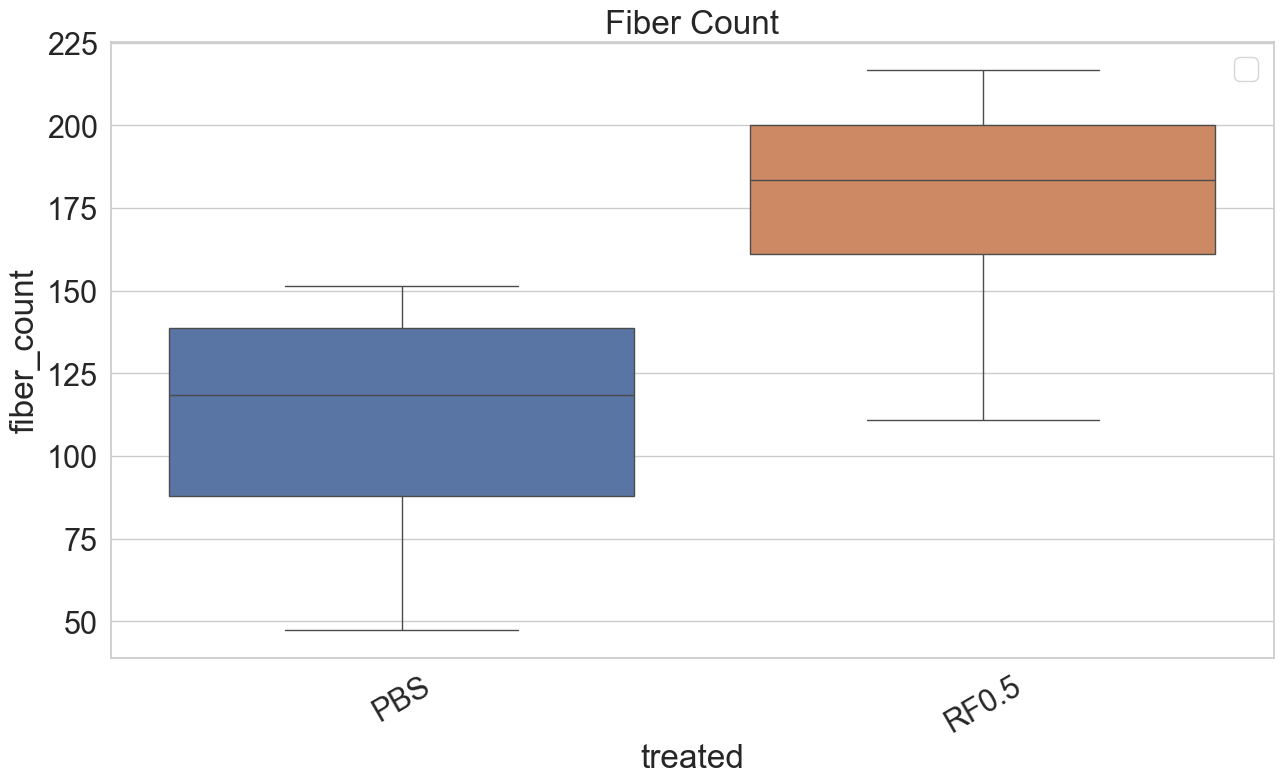

In [152]:
plt.figure(figsize = (15, 8));
sns.boxplot(data = df, #[(df.trt_level == '0.1RF')],#(df.trt_level <= '0.5RF') & 
            x = 'treated',
            y = 'fiber_count',
            hue = 'treated',
            #estimator='median',
            #errorbar='ci',
            #log_scale = True,
            #width=.4,
            #gap = .2,
            #order = ['0.1RF', '0.5RF'],
            #style='treated',
            #err_style='bars'
            );
'''sns.barplot(data = df[(df.trt_level == '0.5RF')],#(df.trt_level <= '0.5RF') & 
            x = 'treated',
            y = 'length',
            hue = 'wv',
            #estimator='median',
            #errorbar='se',
            #log_scale = True,
            #width=.4,
            #gap = .2,
            #order = ['0.1RF', '0.5RF'],
            #style='treated',
            #err_style='bars'
            palette='viridis',
            linestyle = '--',
            #label = '0.5RF'
            #dodge=1,
            fill = False
            )'''
plt.xticks(rotation = 30);
plt.title('Fiber Count');
plt.legend(bbox_to_anchor = (1,1));

In [154]:
stack_properties = []
for file in os.listdir():
    f = os.path.join(file)
    #print(f)
    #print(f.split('\\')[2].split('.t')[0])
    if f.endswith('.tif'):
        img_st = sk.io.imread(f)[:, :, :, 1]
        #print(img_st.shape)
        im_equal = sk.filters.sobel(img_st)
        st_gauss = np.array([sk.filters.gaussian(im) for im in im_equal])
        #print(st_gauss.shape)
        st_canny = np.array([sk.feature.canny(im, sigma = 0) for im in st_gauss])
        st_skeleton = np.array([sk.morphology.skeletonize(im) for im in st_canny])

        view = napari.Viewer(title=f)
        view.add_image(img_st)
        view.add_image(im_equal)
        view.add_image(st_gauss)
        view.add_image(st_canny)
        view.add_image(st_skeleton)
        napari.run()
#Save 3d rendering
        animation = Animation(view)
        animation.capture_keyframe()
        view.camera.zoom *= 1.5
        animation.capture_keyframe()

        animation.animate(f'{f}_3d_img.mp4', fps=30)

Rendering frames...


100%|██████████| 16/16 [00:04<00:00,  3.82it/s]


Rendering frames...


100%|██████████| 16/16 [00:00<00:00, 28.81it/s]


Rendering frames...


100%|██████████| 16/16 [00:00<00:00, 27.71it/s]


In [102]:
properties = []
for id, slice in enumerate(st_skeleton):
    labeled_slice = sk.measure.label(slice)
    props = sk.measure.regionprops(labeled_slice)
    slice_props = [{'slice':id, 'label': prop.label, 'area': prop.area, 'centroid': prop.centroid, 'orientation': prop.orientation, 'length': prop.perimeter} for prop in props]
    properties.extend(slice_props)

In [56]:
fiber_count = []
for id, slice in enumerate(st_skeleton):
    labeled_slice = sk.measure.label(slice)
    num_fibers = labeled_slice.max()
    fiber_count.append({'slice': id, "fiber_count": num_fibers})


In [103]:
view = napari.Viewer()
view.add_image(img_st)
view.add_image(st_gauss)
view.add_image(st_canny)
view.add_image(st_skeleton)
napari.run()

In [83]:
centroid = pd.DataFrame(pd.DataFrame(properties)['centroid'].to_list(), columns= ['centroid_x', 'centroid_y'])

In [84]:
stackprops = pd.concat([pd.DataFrame(properties), centroid], axis = 1)
st_props = stackprops.drop('centroid', axis=1)

In [85]:
st_props

,slice,label,area,orientation,length,centroid_x,centroid_y
0,0,1,4.0,1.455251,2.621320,1.250000,49.500000
1,0,2,26.0,1.521744,26.763456,3.038462,62.230769
2,0,3,25.0,-1.407933,27.349242,2.280000,85.440000
3,0,4,12.0,1.415668,11.656854,2.000000,121.500000
4,0,5,8.0,0.785398,5.828427,3.625000,137.625000
...,...,...,...,...,...,...,...
351819,39,255,6.0,1.570796,7.656854,2098.000000,2815.500000
351820,39,256,16.0,0.976404,18.142136,2118.500000,624.500000
351821,39,257,5.0,1.097410,3.621320,2127.800000,593.000000
351822,39,258,12.0,1.063749,12.278175,2130.666667,592.500000


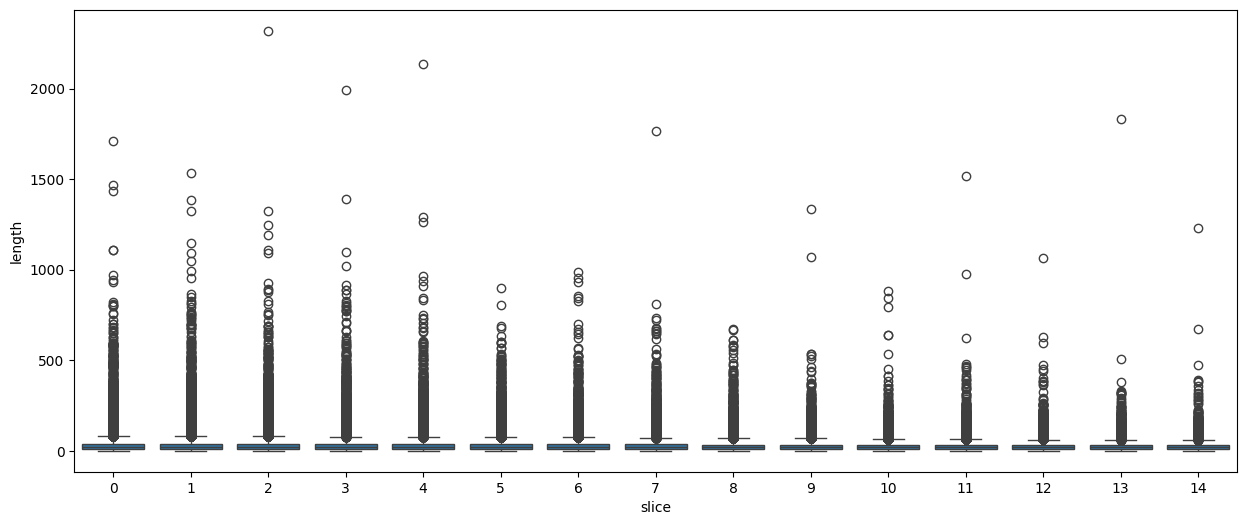

In [86]:
plt.figure(figsize = (15, 6))
sns.boxplot(x = 'slice',
            y = 'length',
            data = st_props[st_props['slice'] < 15]);

In [59]:
pd.DataFrame(fiber_count)

,slice,fiber_count
0,0,35447
1,1,35773
2,2,35488
3,3,35564
4,4,35300
5,5,35032
6,6,34178
7,7,33131
8,8,32605
9,9,31627


In [ ]:
import numpy as np
from skimage import io, filters, feature, measure
import napari

# Step 1: Import the stacked images
def load_image_stack(file_path):
    # Load image stack as a 3D numpy array from a multi-page TIFF or similar format
    image_stack = io.imread(file_path)  # Adjust to load your image stack format
    return image_stack

# Step 2: Apply a Gaussian filter to each slice in the stack
def apply_gaussian_filter(image_stack, sigma=1.0):
    filtered_stack = np.array([filters.gaussian(slice, sigma=sigma) for slice in image_stack])
    return filtered_stack

# Step 3: Find edges using Canny edge detection for each slice in the stack
def find_edges(image_stack, sigma=1.0):
    edges_stack = np.array([feature.canny(slice, sigma=sigma) for slice in image_stack])
    return edges_stack

# Step 4: Measure properties on each labeled region in the stack
def measure_properties(edges_stack):
    properties = []
    for i, slice in enumerate(edges_stack):
        labeled_slice = measure.label(slice)  # Label connected regions
        props = measure.regionprops(labeled_slice)  # Measure properties
        slice_props = [{'slice': i, 'area': prop.area, 'centroid': prop.centroid} for prop in props]
        properties.extend(slice_props)
    return properties

# Step 5: Visualize the original, filtered, and edge-detected images in Napari
def visualize_in_napari(original_stack, filtered_stack, edges_stack):
    with napari.gui_qt():
        viewer = napari.Viewer()
        viewer.add_image(original_stack, name="Original Stack", colormap="gray")
        viewer.add_image(filtered_stack, name="Filtered Stack", colormap="gray")
        viewer.add_image(edges_stack, name="Edges Stack", colormap="gray")

# Putting it all together
file_path = 'path_to_your_image_stack.tif'  # Replace with your image file path
image_stack = load_image_stack(file_path)
filtered_stack = apply_gaussian_filter(image_stack)
edges_stack = find_edges(filtered_stack)
properties = measure_properties(edges_stack)

# Print properties of detected regions
for prop in properties:
    print(f"Slice: {prop['slice']}, Area: {prop['area']}, Centroid: {prop['centroid']}")

# Visualize the results in Napari
visualize_in_napari(image_stack, filtered_stack, edges_stack)
